In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import time
import numpy as np
import multiprocessing
from gurobipy import *
import networkx as nx
import numpy as np
import random
from networktools.frustrationIndex import frustration_index
from networktools.SB_measures import *
from networktools.ensembles import *
from networktools.utility import *
import matplotlib.pyplot as plt

Create simple graphs

In [8]:
G = nx.complete_graph(4)

edge_signs = {(0, 1): 1, (0, 2): 1, (0, 3): -1, (1, 2): -1, (1, 3): 1, (2, 3): 1}
nx.set_edge_attributes(G, edge_signs, 'weight')
nx.get_edge_attributes(G, 'weight')

G2 = nx.complete_graph(4)

edge_signs = {(0, 1): 1, (0, 2): 1, (0, 3): -1, (1, 2): 1, (1, 3): 1, (2, 3): -1}
nx.set_edge_attributes(G2, edge_signs, 'weight')
nx.get_edge_attributes(G2, 'weight')

{(0, 1): 1, (0, 2): 1, (0, 3): -1, (1, 2): 1, (1, 3): 1, (2, 3): -1}

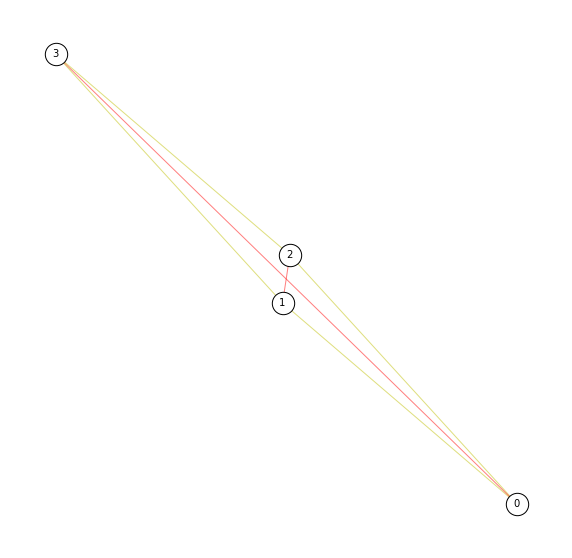

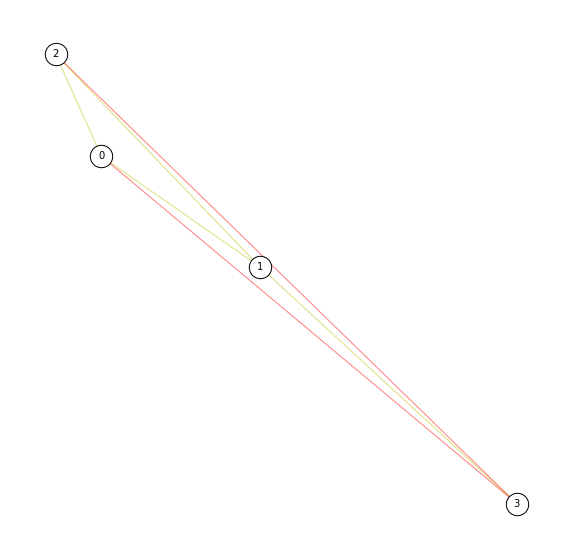

In [9]:
plot_signed_graph(G)
plot_signed_graph(G2)

Calculating the frustration index

In [10]:
%%capture
F_G = frustration_index(nx.to_numpy_matrix(G))

F_G2 = frustration_index(nx.to_numpy_matrix(G2))

In [11]:
print(F_G[0], F_G2[0], "(Should be 2.0 1.0 respectively)")

2.0 1.0 (Should be 2.0 1.0 respectively)


Create network with triangles

In [12]:
A = nx.to_numpy_array(G)
A2 = nx.to_numpy_array(G2)

A3 = np.random.choice([-1, 0, 1], size=(10, 10), p=[0.2, 0.6, 0.2])
A3 = np.triu(A3, k=1) + np.triu(A3, k=1).T

In [13]:
G4 = generate_powerlaw_cluster_reshuffling(n=30,m=5, p = 0.8, signed_links = np.concatenate((np.repeat(1, 70),(np.repeat(-1, 55)))))
G4 = nx.from_numpy_array(G4)
A4 = nx.to_numpy_array(G4)

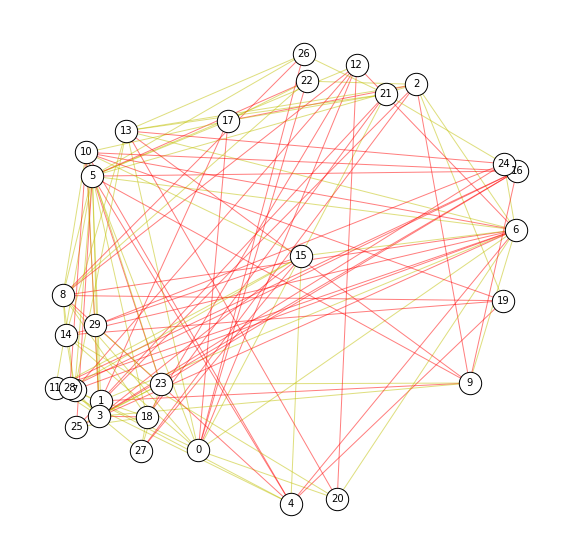

In [14]:
plot_signed_graph(G4)

In [15]:
nx.average_clustering(G4)

0.46620375381985296

Powerlaw/clustering reshuffling

In [16]:
n_sim = 10

In [17]:
series_pow = powerlaw_cluster_reshuffling(A4,n_sim=n_sim,parallel= True,n_cores=4)

[25.0, 5.0]


In [18]:
clust_pow = [nx.average_clustering(nx.from_numpy_array(x)) for x in series_pow]

In [19]:
np.mean(clust_pow)

0.4713457634992498

In [20]:
%%capture
frust_pow = [frustration_index(x)[0] for x in series_pow]
frust_ref = frustration_index(A4)[0]

In [21]:
print(frust_ref, np.mean(frust_pow), np.std(frust_pow))

32.0 31.3 2.2825424421026654


G(n,m) reshuffling

In [22]:
series_gnm = gnm_reshuffling(A4,n_sim=n_sim,parallel= True,n_cores=4)

In [23]:
%%capture
frust_gnm = [frustration_index(x)[0] for x in series_gnm]

In [24]:
clust_gnm = [nx.average_clustering(nx.from_numpy_array(x)) for x in series_gnm]

In [25]:
np.mean(clust_gnm)

0.2768167388167388

In [26]:
print(frust_ref, np.mean(frust_gnm), np.std(frust_gnm))

32.0 32.0 0.0


Fixed topology reshuffling

In [27]:
series_FT = sign_reshuffling_on_fixed_topology(A4,n_sim=n_sim,parallel= True,n_cores=4)

In [28]:
%%capture
frust_FT = [frustration_index(x)[0] for x in series_FT]

In [29]:
print(frust_ref, np.mean(frust_FT), np.std(frust_FT))

32.0 33.2 2.1354156504062622


In [31]:
A5 =  balanced_graph(A4)

15


In [32]:
n_sim = 10

In [33]:
%%capture

series_gnm = gnm_reshuffling(A5,n_sim=n_sim,parallel= True,n_cores=4)
series_FT = sign_reshuffling_on_fixed_topology(A5,n_sim=n_sim,parallel= True,n_cores=4)
series_pow = powerlaw_cluster_reshuffling(A5,n_sim=n_sim,parallel= True,n_cores=4)

frust_gnm = [frustration_index(x)[0] for x in series_gnm]
frust_FT = [frustration_index(x)[0] for x in series_FT]
frust_pow = [frustration_index(x)[0] for x in series_pow]

frust_ref = frustration_index(A5)[0]

In [34]:
print(frust_ref, np.mean(frust_gnm), np.mean(frust_FT), np.mean(frust_pow))

0.0 31.8 33.6 31.9


In [35]:
print(len(A5[A5==1]),len(A5[A5==-1]),len(A5[A5==0]))

134 116 650


In [36]:
A6 = random_sign_switch(A5, 0.1)

In [37]:
%%capture

series_gnm = gnm_reshuffling(A6,n_sim=n_sim,parallel= True,n_cores=4)
series_FT = sign_reshuffling_on_fixed_topology(A6,n_sim=n_sim,parallel= True,n_cores=4)
series_pow = powerlaw_cluster_reshuffling(A6,n_sim=n_sim,parallel= True,n_cores=4)

frust_gnm = [frustration_index(x)[0] for x in series_gnm]
frust_FT = [frustration_index(x)[0] for x in series_FT]
frust_pow = [frustration_index(x)[0] for x in series_pow]

frust_ref = frustration_index(A6)[0]

In [38]:
print(frust_ref, np.mean(frust_gnm), np.mean(frust_FT), np.mean(frust_pow))

11.0 29.0 32.7 32.3


It seems that the three null-models always yield very similar results. Let's test how this looks when we run the null-models with different initial distribution of 0,1,-1

In [39]:
pluses = np.linspace(20,120,6)
minuses = 125 - pluses

In [40]:
Gs= [generate_powerlaw_cluster_reshuffling(n=30,m=5, p = 0.8, signed_links = np.concatenate((np.repeat(1, x),(np.repeat(-1, y))))) for x,y in zip(pluses,minuses)]

In [41]:
n_sim = 2

In [42]:
Gs[0]

array([[ 0.,  0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  0.,  0.,  1., -1.,
         0., -1., -1.,  1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0., -1.,  0.,
         0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0., -1.,  0.,  0., -1.,
         0., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  1., -1., -1.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0., -1., -1., -1.,  0., -1., -1.,
         1., -1.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.,
         0., -1.,  0., -1.],
       [ 1., -1., -1.,  1., -1.,  0., -1.,  1., -1., -1., -1.,  0., -1.,
        -1.,  0.,  0.,  1., -1., -1., -1., -1.,  0.,

In [43]:
%%capture

gnm_vec = []
FT_vec = []
pow_vec = []
ref_vec = []


for i in range(len(Gs)):
    series_gnm = gnm_reshuffling(Gs[i],n_sim=n_sim,parallel= True,n_cores=4)
    series_FT = sign_reshuffling_on_fixed_topology(Gs[i],n_sim=n_sim,parallel= True,n_cores=4)
    series_pow = powerlaw_cluster_reshuffling(Gs[i],n_sim=n_sim,parallel= True,n_cores=4)

    frust_gnm = [frustration_index(x)[0] for x in series_gnm]
    frust_FT = [frustration_index(x)[0] for x in series_FT]
    frust_pow = [frustration_index(x)[0] for x in series_pow]

    frust_ref = frustration_index(Gs[i])[0]

    gnm_vec.append(np.mean(frust_gnm))
    FT_vec.append(np.mean(frust_FT))
    pow_vec.append(np.mean(frust_pow))
    ref_vec.append(frust_ref)


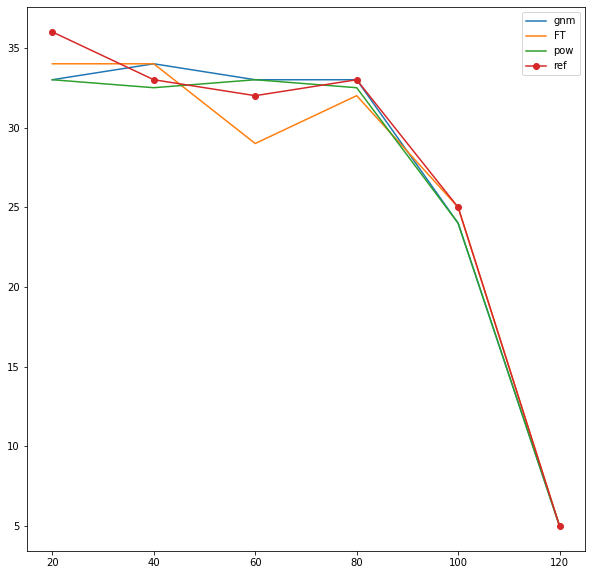

In [43]:
plt.figure(figsize=(10,10))
plt.plot(pluses, gnm_vec, label = 'gnm')
plt.plot(pluses, FT_vec, label = 'FT')
plt.plot(pluses, pow_vec, label = 'pow')
plt.plot(pluses, ref_vec, label = 'ref', marker = 'o')
plt.legend()
plt.show()

Trying on a circular graph

In [52]:
n_agents = 10

In [53]:
circ_graph = nx.cycle_graph(n_agents)
A = nx.to_numpy_array(circ_graph)

In [55]:
A = nx.to_numpy_array(circ_graph)

In [56]:
n_sim = 100

In [49]:
%%capture


series_gnm = gnm_reshuffling(A,n_sim=n_sim,parallel= True,n_cores=4)
series_FT = sign_reshuffling_on_fixed_topology(A,n_sim=n_sim,parallel= True,n_cores=4)
series_pow = powerlaw_cluster_reshuffling(A,n_sim=n_sim,parallel= True,n_cores=4)

frust_gnm = [frustration_index(x)[0] for x in series_gnm]
frust_FT = [frustration_index(x)[0] for x in series_FT]
frust_pow = [frustration_index(x)[0] for x in series_pow]

frust_ref = frustration_index(A)[0]



In [50]:
print(np.mean(frust_gnm), np.mean(frust_FT), np.mean(frust_pow), frust_ref)

2.69 2.67 2.58 0.0


In [51]:
print(np.std(frust_gnm), np.std(frust_FT), np.std(frust_pow))

0.702780193232564 0.9279547402756236 0.8388086790204308


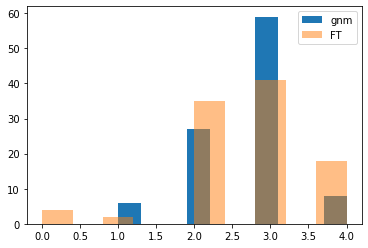

In [52]:
plt.hist(frust_gnm, label = 'gnm')  
plt.hist(frust_FT, label = 'FT', alpha = 0.5)
plt.legend()
plt.show()

In [53]:
sum(nx.triangles(nx.from_numpy_array(series_FT[0])).values())/3

8.0

In [54]:
frust_FT[0]

2.0

0.10333333333333332


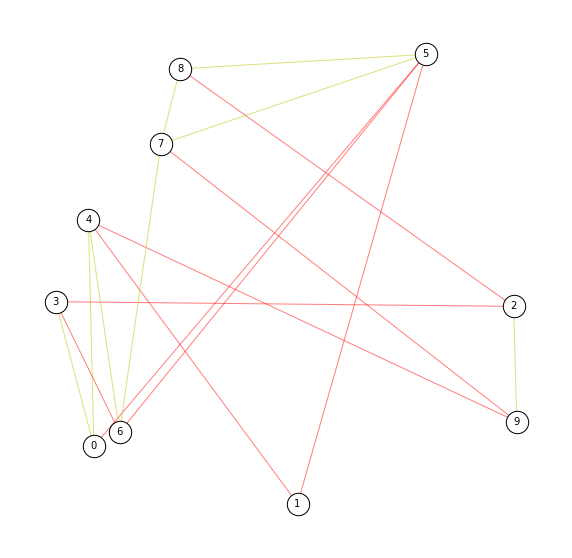

In [55]:
print(nx.average_clustering(nx.from_numpy_array(series_gnm[0])))
plot_signed_graph(nx.from_numpy_array(series_gnm[0]))

0.6888888888888889


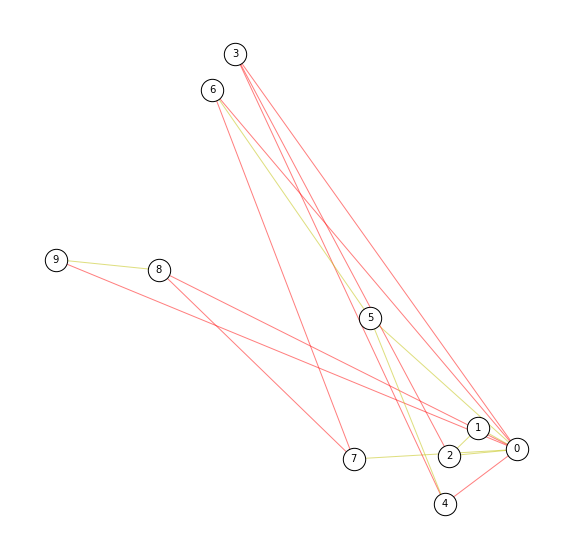

In [56]:
print(nx.average_clustering(nx.from_numpy_array(series_FT[0])))
plot_signed_graph(nx.from_numpy_array(series_FT[0]))

0.5983333333333333


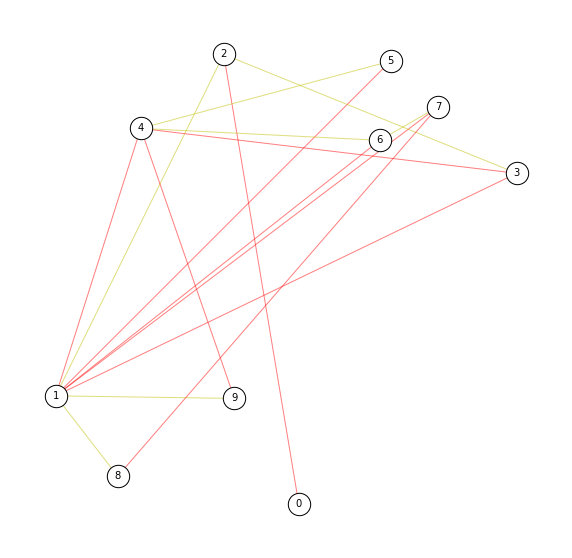

In [57]:
print(nx.average_clustering(nx.from_numpy_array(series_pow[0])))
plot_signed_graph(nx.from_numpy_array(series_pow[0]))

0.6888888888888889


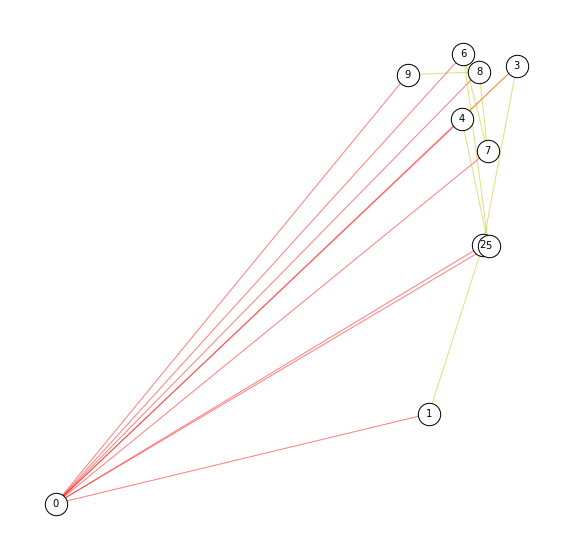

In [58]:
print(nx.average_clustering(nx.from_numpy_array(A)))
plot_signed_graph(nx.from_numpy_array(A))

In [59]:
# testing the implementation of the frustration index

G_test = nx.Graph()
G_test.add_edges_from([(1,2),(1,3),(2,3),(1,4),(3,5),(2,6),(4,5)])
nx.set_edge_attributes(G_test, {(1,2):-1, (1,3):-1, (2,3):1, (1,4):-1, (3,5):+1, (2,6):-1, (4,5):1}, 'weight')
A_test = nx.to_numpy_array(G_test)

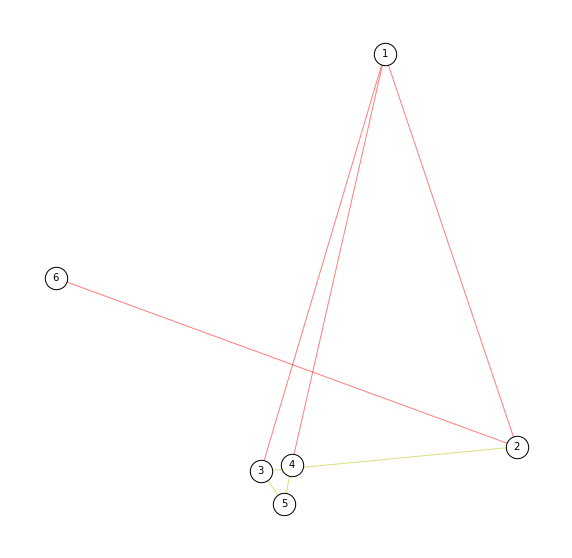

In [60]:
plot_signed_graph(G_test)

In [61]:
frustration_index(A_test)

Set parameter Threads to value 8
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 6 columns and 1 nonzeros
Model fingerprint: 0x5a6bb401
Model has 7 quadratic objective terms
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 1 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 0 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bo

(0.0, 0, 0.011714935302734375)

Outside star configuration

In [78]:
%%capture
n_sim = 100

series_gnm = gnm_reshuffling(A_circ,n_sim=n_sim,parallel= True,n_cores=4)
series_FT = sign_reshuffling_on_fixed_topology(A_circ,n_sim=n_sim,parallel= True,n_cores=4)
series_pow = powerlaw_cluster_reshuffling(A_circ,n_sim=n_sim,parallel= True,n_cores=4)

frust_gnm = [frustration_index(x)[0] for x in series_gnm]
frust_FT = [frustration_index(x)[0] for x in series_FT]
frust_pow = [frustration_index(x)[0] for x in series_pow]

frust_ref = frustration_index(A)[0]



In [79]:
print(np.mean(frust_gnm), np.mean(frust_FT), np.mean(frust_pow), frust_ref)

4.19 5.3 5.92 0.0


In [80]:
n_agents*12/27

4.444444444444445

In [81]:
def calc_triangles(arr):
    return sum([x for x in nx.triangles(nx.from_numpy_array(arr)).values()])/3

In [93]:
calc_triangles(series_pow[0])

13.0

In [83]:
nx.average_clustering(nx.from_numpy_array(series_pow[0]))

0.5192460317460317

Ring-Regular network

In [84]:
ring_regular = nx.to_numpy_array(nx.newman_watts_strogatz_graph(10, 4, 0))

In [85]:
A_ringReg = balanced_graph(ring_regular)

5


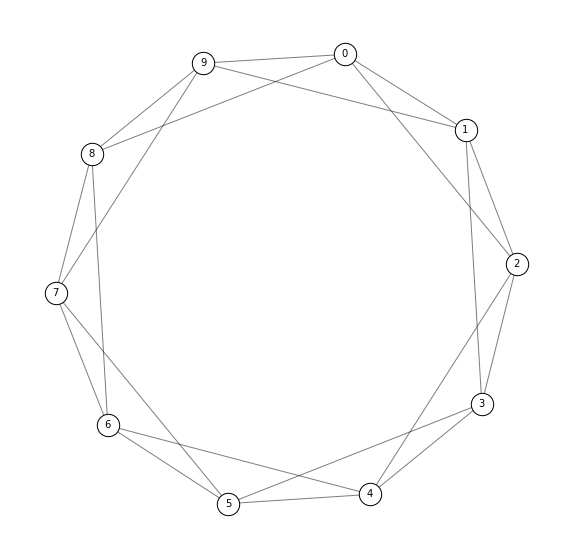

In [86]:
plot_graph(nx.from_numpy_array(abs(A_ringReg)))

Replicating Aref results

In [78]:
n = 15
m = 50

reps = 50
minuses = np.linspace(0,m,11).astype(int)

minuses = np.repeat(minuses, reps)

init_graph = create_gnm_graph(n, m)

Gs= [random_sign_switch_nedges(init_graph,x) for x in minuses]

In [79]:
%%capture
frust_gnm = [frustration_index(x)[0] for x in Gs]
norm_frust = [1 - x/(m/2) for x in frust_gnm]

estrada_gnm = [estrada_balance(x)[1] for x in Gs]
algebraic_conflict_gnm = [algebraic_conflict(x) for x in Gs]
triangle_index_gnm = [triangle_index(x) for x in Gs]

In [80]:
n_triangles = calc_triangles(init_graph)
n_triangles

41.0

In [81]:
norm_frust_mean = np.average(np.array(norm_frust).reshape(-1, reps), axis=1)
estrada_gnm_mean = np.average(np.array(estrada_gnm).reshape(-1, reps), axis=1)
algebraic_conflict_gnm_mean = np.average(np.array(algebraic_conflict_gnm).reshape(-1, reps), axis=1)
triangle_index_gnm_mean = np.average(np.array(triangle_index_gnm).reshape(-1, reps), axis=1)
minuses_mean = np.average(np.array(minuses).reshape(-1, reps), axis=1)

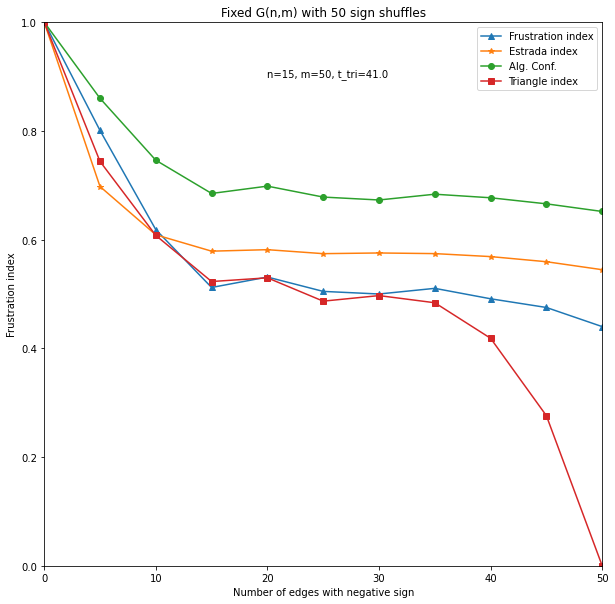

In [82]:
alpha = 1
plt.figure(figsize=(10,10))
plt.title('Fixed G(n,m) with 50 sign shuffles')
plt.xlabel('Number of edges with negative sign')
plt.ylabel('Frustration index')
plt.xlim(0,m)
plt.ylim(0,1)
plt.text(20,.9,'n='+str(n)+', m='+str(m)+ ', t_tri='+str(n_triangles))
plt.plot(minuses_mean, norm_frust_mean,alpha=alpha, label='Frustration index', marker='^')
plt.plot(minuses_mean, estrada_gnm_mean,alpha=alpha, label='Estrada index', marker='*')
plt.plot(minuses_mean, algebraic_conflict_gnm_mean,alpha=alpha, label='Alg. Conf.', marker='o')
plt.plot(minuses_mean, triangle_index_gnm_mean,alpha=alpha, label='Triangle index', marker='s')
plt.legend()
plt.savefig('plots/gnm_'+str(n)+'_'+str(m)+'.png')
plt.savefig('plots/gnm_'+str(n)+'_'+str(m)+'.pdf')

In [83]:
print(m, n,calc_triangles(init_graph))

50 15 41.0


Difference to powerlaw clustering topology

In [84]:
# roughly 50 edges with n=15, m=5, p = 0.8
n = 15
m = 5
p = 0.8

M = m*(n-m)
M

50

In [85]:
reps = 30
minuses = np.linspace(0,M,11).astype(int)

minuses = np.repeat(minuses, reps)

init_graph = nx.powerlaw_cluster_graph(n,m,p=p)

init_graph = nx.to_numpy_array(init_graph)

Gs= [random_sign_switch_nedges(init_graph,x) for x in minuses]

edgs = init_graph.sum()/2
edgs

50.0

In [86]:
%%capture
frust_pow = [frustration_index(x)[0] for x in Gs]
norm_frust_pow = [1 - x/(M/2) for x in frust_pow]

estrada_pow = [estrada_balance(x)[1] for x in Gs]
algebraic_conflict_pow = [algebraic_conflict(x) for x in Gs]
triangle_index_pow = [triangle_index(x) for x in Gs]

norm_frust_pow_mean = np.average(np.array(norm_frust_pow).reshape(-1, reps), axis=1)
estrada_pow_mean = np.average(np.array(estrada_pow).reshape(-1, reps), axis=1)
algebraic_conflict_pow_mean = np.average(np.array(algebraic_conflict_pow).reshape(-1, reps), axis=1)
triangle_index_pow_mean = np.average(np.array(triangle_index_pow).reshape(-1, reps), axis=1)
minuses_mean = np.average(np.array(minuses).reshape(-1, reps), axis=1)

In [87]:
n_triangles = calc_triangles(init_graph)
n_triangles

61.0

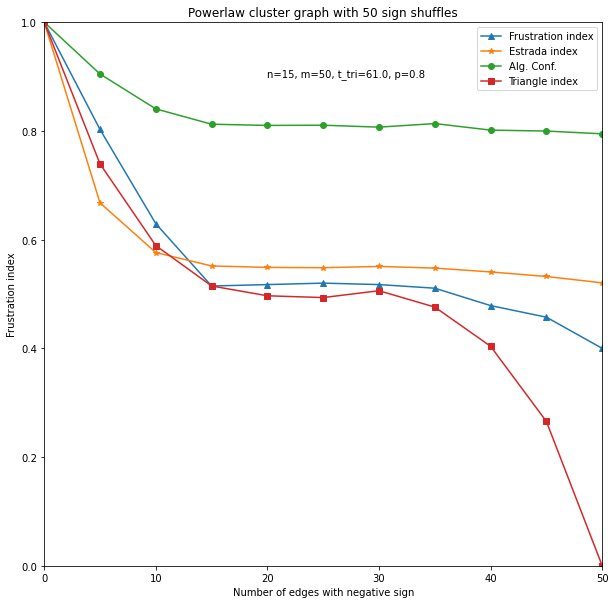

In [88]:
alpha = 1
plt.figure(figsize=(10,10))
plt.title('Powerlaw cluster graph with 50 sign shuffles')
plt.xlabel('Number of edges with negative sign')
plt.ylabel('Frustration index')
plt.xlim(0,M)
plt.ylim(0,1)
plt.text(20,.9,'n='+str(n)+', m='+str(M)+ ', t_tri='+str(n_triangles)+ ', p='+str(p))
plt.plot(minuses_mean, norm_frust_pow_mean,alpha=alpha, label='Frustration index', marker='^')
plt.plot(minuses_mean, estrada_pow_mean,alpha=alpha, label='Estrada index', marker='*')
plt.plot(minuses_mean, algebraic_conflict_pow_mean,alpha=alpha, label='Alg. Conf.', marker='o')
plt.plot(minuses_mean, triangle_index_pow_mean,alpha=alpha, label='Triangle index', marker='s')
plt.legend()
plt.savefig('plots/pow_'+str(n)+'_'+str(edgs)+'.png')
plt.savefig('plots/pow_'+str(n)+'_'+str(edgs)+'.pdf')


In [89]:
############ this investigation is not finished.

In [90]:
np.linalg.eigvals(Gs[1])

array([ 7.47210415,  2.84208022, -3.30839198, -2.75529246,  1.64303242,
       -2.31516081,  1.07422422,  0.94050618, -1.88142224, -1.20979949,
       -1.32209174,  0.15202516, -0.20467967, -0.60598762, -0.52114633])

In [91]:
np.count_nonzero(Gs[1])

100

In [92]:
import copy
import itertools

In [93]:
from tqdm import tqdm

In [98]:
ind, cof = pointIndex(Gs[300])

105it [00:00, 1859.81it/s]00<?, ?it/s]
455it [00:00, 1899.04it/s]
1365it [00:00, 2482.65it/s]0<00:01,  6.63it/s]
3003it [00:00, 3065.28it/s]0<00:03,  3.14it/s]
881it [00:00, 3426.87it/s]01<00:06,  1.77it/s]
 33%|███▎      | 5/15 [00:02<00:04,  2.38it/s]


In [99]:
GG = copy.deepcopy(Gs[300])

In [100]:
degs = [x[1] for x in list(nx.from_numpy_array(abs(GG)).degree())]
laplacian = np.diag(degs) - GG

eigvals = np.linalg.eigvals(laplacian)
eigvals = np.around(eigvals, decimals=10) # round to 5 decimals as the eigenvalue 0 is sometimes not exactly found

#smallest_ev = min(eigvals)
multiplicity_zeroEig = GG.shape[0] - np.count_nonzero(eigvals)

connected_components = list(nx.connected_components(nx.from_numpy_array(abs(GG))))
n_components = len(connected_components)

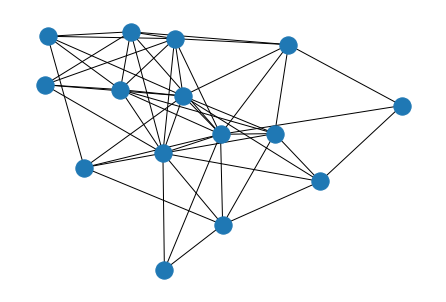

In [101]:
nx.draw(nx.from_numpy_array(abs(GG)))

In [102]:
connected_components

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}]

In [103]:
GG[:,cof] = 0
GG[cof,:] = 0

In [104]:
ind, cof = pointIndex_triads(Gs[300])

105it [00:00, 16339.02it/s]0<?, ?it/s]
455it [00:00, 12268.70it/s]
1365it [00:00, 17465.28it/s]
3003it [00:00, 22015.55it/s]<00:00, 22.71it/s]
/home/geandres/Documents/Github/complex-system-toolbox/networktools/SB_measures.py:63: RuntimeWarning: invalid value encountered in double_scalars
  trace_s = (trace_s + trace_us)/(2*trace_us)
5005it [00:00, 22814.18it/s]
6435it [00:00, 23261.20it/s]
6435it [00:00, 22934.03it/s]<00:01,  6.96it/s]
5005it [00:00, 24744.44it/s]
3003it [00:00, 22759.13it/s]<00:01,  5.57it/s]
1365it [00:00, 20441.32it/s]<00:01,  5.87it/s]
455it [00:00, 21135.03it/s]
105it [00:00, 17686.82it/s]
15it [00:00, 9510.89it/s]0:01<00:00,  9.37it/s]
1it [00:00, 3358.13it/s]
0it [00:00, ?it/s]
100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


In [106]:
G1 = create_gnm_graph(n, m)

In [107]:
np.around(G1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [102]:
A = createFullyConnected(10)

In [103]:
random_sign_switch_nedges(A, 10)

array([[ 0.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.],
       [ 1.,  0., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1.,  0.,  1.,  1., -1.,  1.,  1.,  1.,  1.],
       [-1.,  1.,  1.,  0., -1., -1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., -1.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1., -1., -1.,  1.,  0., -1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1.,  1., -1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  0.,  1.],
       [-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.]])